# **Deep Learning Project**

### **Task Definition**
This project addresses a **multi-output learning task**, combining:
- **Binary classification** (Good vs Bad review)
- **Regression** (Predicting the numerical score)

As explained in *point 1*, both outputs are modeled simultaneously in order to analyze how the model scores different kinds of reviews. This approach helps interpret whether low scores always correspond to bad reviews and vice versa.


# **Importing Libraries**

In [ ]:
#!pip install keras-tuner

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Concatenate, Flatten,
    BatchNormalization, Dropout, Activation
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from collections import Counter
import keras_tuner as kt
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# **Importing Dataset**

The dataset is loaded from a GitHub URL and used without changes.

It contains multiple types of fields (text, dates, categorical, numeric), which will be treated as explained in *point 2a of the solution*.

In [ ]:
# Download the dataset from GitHub and read it into a DataFrame
DATA_URL = "https://raw.githubusercontent.com/lucreziaabernini/hotel-reviews-dl/main/input_data.csv"
response = requests.get(DATA_URL)
response.raise_for_status()

df = pd.read_csv(StringIO(response.text))
print("Dataset loaded:", df.shape)

Dataset loaded: (13772, 10)


### Check

In [ ]:
df

,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
1,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
2,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
3,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
4,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review
...,...,...,...,...,...,...,...,...,...,...
13767,150 150 Bayswater Road Kensington and Chelsea ...,3/9/2016,8.4,DoubleTree by Hilton London Hyde Park,Italy,2405,16,7.5,Cleanliness room temperature location Facilities,Good_review
13768,2 2 Rue Hector Malot 12th arr 75012 Paris France,9/1/2015,8.5,Novotel Paris Gare De Lyon,United Kingdom,3583,6,8.8,The cost of the parking The location,Good_review
13769,18 18 Albert Embankment Lambeth London SE1 7TJ UK,9/4/2016,8.3,Park Plaza London Riverbank,United Kingdom,4684,1,10.0,The staff was very helpful,Good_review
13770,26 26 Cadogan Gardens Kensington and Chelsea L...,10/6/2015,9.2,Draycott Hotel,Switzerland,245,9,10.0,Tout A home away from home,Good_review


Let's list the dataset's column names just to check that everything was imported in a correct way.

In [ ]:
print(df.columns.tolist())

['Hotel_Address', 'Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', 'Hotel_number_reviews', 'Reviewer_number_reviews', 'Review_Score', 'Review', 'Review_Type']


In [ ]:
print(df.dtypes)

Hotel_Address               object
Review_Date                 object
Average_Score              float64
Hotel_Name                  object
Reviewer_Nationality        object
Hotel_number_reviews         int64
Reviewer_number_reviews      int64
Review_Score               float64
Review                      object
Review_Type                 object
dtype: object


## Define **Target Variables**
According to the task described in *point 1*, we have two targets:
- Binary classification target (`Review_Type`) → 0 for Bad, 1 for Good
- Regression target (`Review_Score`) → a continuous value


In [ ]:
y_class = df["Review_Type"].map({"Bad_review": 0, "Good_review": 1}).values
y_reg = df['Review_Score'].values

# **Dataset Splitting (Train/Test/Val)**

As stated in *question 6*, I will here divide the dataset into:
- **Training set** → for learning
- **Validation set** → for tuning hyperparameters
- **Test set** → for final model evaluation only

I will perform 2 splits: an **Initial Split** where 80% of the data is reserved for training and validation and 20% is set aside as the final test set and an **Internal Split** only from the 80% of the before-mentioned Initial Split.

**Important note:**  
I split the dataset **before any preprocessing** (e.g. tokenization, encoding, normalization) to avoid **data leakage**.  
This ensures that no information from the test or validation sets is used to build preprocessing artifacts (e.g. tokenizer vocabulary, category mappings).

This is essential to:
- Preserve generalization ability
- Avoid optimistic bias in evaluation metrics
- Ensure reproducibility and correctness of the learning process


In [ ]:
# First split: 80% for train+val, 20% for test
df_train_val, df_test, y_train_val_class, y_test_class, y_train_val_reg, y_test_reg = train_test_split(
    df, y_class, y_reg, test_size=0.2, random_state=42, stratify=y_class
)

# Second split: Split train+val into 80% train and 20% val (which is 16% of original)
  # test_size=0.25 because 0.25 * 0.80 = 0.20 (20% of original data for validation)
df_train, df_val, y_train_class, y_val_class, y_train_reg, y_val_reg = train_test_split(
    df_train_val, y_train_val_class, y_train_val_reg, test_size=0.25, random_state=42, stratify=y_train_val_class
)

# Group target variables in dictionaries, as expected by the Keras multi-output model
y_train = {'classification': y_train_class, 'regression': y_train_reg}
y_val = {'classification': y_val_class, 'regression': y_val_reg}

### Check

After splitting the dataset, I verify that the dimensions match the expected proportions (64% train, 16% val, 20% test).

This ensures the data was split correctly and that no records were lost.

In [ ]:
print("Total dataset size:", len(df))
print("Train+Val:", len(df_train_val))
print("  - Train:", len(df_train))
print("  - Val:  ", len(df_val))
print("Test:", len(df_test))

print("\nTrain target shapes:", y_train_class.shape, y_train_reg.shape)
print("Val target shapes:", y_val_class.shape, y_val_reg.shape)
print("Test target shapes:", y_test_class.shape, y_test_reg.shape)

Total dataset size: 13772
Train+Val: 11017
  - Train: 8262
  - Val:   2755
Test: 2755

Train target shapes: (8262,) (8262,)
Val target shapes: (2755,) (2755,)
Test target shapes: (2755,) (2755,)


# **Preprocessing**

As written in my solution - *answer 2* -, inputs are handled differently depending on their nature:

- **Strings** (`Hotel_Name`, `Reviewer_Nationality`) → mapped to embeddings  
- **Dates** (`Review_Date`) → split into year and month  
  - Year: embedded  
  - Month: one-hot encoded  
- **Texts** (`Review`, `Hotel_Address`) → tokenized, lowercased, padded, passed to embedding + LSTM  
- **Numerical values** (`Reviewer_num_reviews`, `Hotel_number_reviews`) → used directly

After preprocessing, all components are concatenated before being passed to an MLP, as described in *answer 2b*.

## **String** Features

Here, categorical strings are converted to integer IDs to be later passed to an embedding layer.

In [ ]:
# Create dictionaries to map hotel names and nationalities to unique integer IDs
  # These integer indices will be used as input to embedding layers
hotel_name_to_id = {name: i for i, name in enumerate(df_train['Hotel_Name'].unique())}
nat_to_id = {nat: i for i, nat in enumerate(df_train['Reviewer_Nationality'].unique())}

## **Date** Feature

As stated in the solution, I will here extract structured temporal features from the `Review_Date` field.

The goal is to separately handle year and month for embedding and one-hot encoding.

In [ ]:
# Split Review_Date when the '/' occurs to get numerical month and year
def split_year_month(date_series):
    months = []
    years = []
    for d in date_series:
        try:
            parts = d.split('/')
            month = int(parts[0])
            year = int(parts[2])
        except:
            # Default fallback if parsing fails
            month = 1
            year = 2000
        months.append(month)
        years.append(year)
    return np.array(months), np.array(years)

In [ ]:
# One-hot encode the month into a 12-dimensional binary vector
def one_hot_month(months):
    one_hot = np.zeros((len(months), 12))
    for i, m in enumerate(months):
        # Ensure month index is valid (0-11)
        if 1 <= m <= 12:
            one_hot[i, m-1] = 1
        else:
             one_hot[i, 0] = 1  # fallback to January
    return one_hot

In [ ]:
# Extract year and month from the Review_Date string
years_train, months_train = split_year_month(df_train['Review_Date'])
years_val, months_val = split_year_month(df_val['Review_Date'])

Now, map unique years to integers IDs for being passed to the embedding.

In [ ]:
# Build a mapping from year to integer ID for the embedding layer (e.g. 2016 → 0, 2017 → 1, etc.)
year_to_id = {y: i for i, y in enumerate(sorted(np.unique(years_train)))}

## **Text** Features

**Token Statistics and Vocabulary Estimation**

As outlined in *point 2a* of the written solution, before tokenizing and feeding text to the model, we analyze the structure of the review and address fields.

Specifically, I:
- Count the number of words in each address and review to define the **maximum sequence lengths**
- Estimate the number of **unique words** (vocabulary size) to decide how large the embedding spaces should be

This ensures to:
- Avoid wasting memory on rare/uninformative tokens
- Avoid overfitting by cutting long outlier sequences

In [ ]:
# Measure word counts in address and review
address_lengths = df['Hotel_Address'].apply(lambda x: len(x.split()))
print('Stats Hotel_Address lengths:')
print(address_lengths.describe())

review_lengths = df['Review'].apply(lambda x: len(x.split()))
print('Stats Review lengths:')
print(review_lengths.describe())

# Count number of unique words (for vocabulary sizing)
def count_unique_words(texts):
    words = []
    for txt in texts:
        words.extend(txt.lower().split())
    return len(set(words))

unique_addr_words = count_unique_words(df['Hotel_Address'])
unique_review_words = count_unique_words(df['Review'])

print(f"Unique words in Hotel_Address: {unique_addr_words}")
print(f"Unique words in Review: {unique_review_words}")

Stats Hotel_Address lengths:
count    13772.000000
mean        10.238164
std          1.439528
min          7.000000
25%          9.000000
50%         10.000000
75%         11.000000
max         17.000000
Name: Hotel_Address, dtype: float64
Stats Review lengths:
count    13772.000000
mean        25.809178
std         42.513262
min          0.000000
25%          5.000000
50%          9.000000
75%         30.000000
max        614.000000
Name: Review, dtype: float64
Unique words in Hotel_Address: 2421
Unique words in Review: 11975


The vocabulary size for both review and address fields has been selected based on the actual token statistics:

- Review field contains ~12k unique words, but 75% of reviews are under 30 words long.  
- Address field contains ~2.4k unique words, with 75% of addresses under 11 words.

To reduce memory usage and training time, we select:
- `VOCAB_SIZE_REVIEW = 5000`: covers the most common words while filtering out rare outliers.
- `VOCAB_SIZE_ADDR = 1000`: more than enough for short and repetitive address formats.

Moreover:
- *Addresses* are always short → limit them to 10 words for both uniformity and efficiency.
- *Reviews* have long outliers, but majority is under 30 words → cut to 50 to avoid overfitting.

In [ ]:
# Final configuration based on text statistics and memory constraints
MAX_LEN_ADDR = 10
MAX_LEN_REVIEW = 50
VOCAB_SIZE_ADDR = 1000
VOCAB_SIZE_REVIEW = 5000

Next, I configure the tokenizer to:
- Use the most frequent `N` words (`num_words`) as vocabulary
- Replace unseen/rare tokens with a special `<OOV>` token, making sure that the model is able to generalize to new inputs without errors

Tokenizer is only fit on the training set to avoid leakage.

In [ ]:
tokenizer_review = Tokenizer(num_words=VOCAB_SIZE_REVIEW, oov_token="<OOV>")
tokenizer_review.fit_on_texts(df_train['Review'].str.lower()) # Fit only on train

In [ ]:
tokenizer_addr = Tokenizer(num_words=VOCAB_SIZE_ADDR, oov_token="<OOV>")
tokenizer_addr.fit_on_texts(df_train['Hotel_Address'].str.lower()) # Fit only on train

## **Input Preparation** Function

As described in *point 2b*, the different input types are transformed and packed into a unified format to feed into the model.

Features include:
- Tokenizes review and address fields
- Encodes categorical fields with their integer IDs
- Converts dates into numeric + one-hot format
- Uses numerical fields directly

All are returned as a dictionary, as expected by the model.

They will be later concatenated as a single input tensor.

In [ ]:
# Return dictionary of all transformed fields to be fed to model
def prepare_input(df, tokenizer_review, tokenizer_addr):
    review_seq = pad_sequences(tokenizer_review.texts_to_sequences(df['Review'].str.lower()), maxlen=MAX_LEN_REVIEW, padding='post', truncating='post')
    addr_seq = pad_sequences(tokenizer_addr.texts_to_sequences(df['Hotel_Address'].str.lower()), maxlen=MAX_LEN_ADDR, padding='post', truncating='post')

    hotel_name_enc = df['Hotel_Name'].map(lambda x: hotel_name_to_id.get(x, 0)).astype(int).values
    nat_enc = df['Reviewer_Nationality'].map(lambda x: nat_to_id.get(x, 0)).astype(int).values

    months, years = split_year_month(df['Review_Date'])
    years_enc = pd.Series(years).map(lambda x: year_to_id.get(x, 0)).astype(int).values
    months_oh = one_hot_month(months)

    hotel_num_reviews = df['Hotel_number_reviews'].values.reshape(-1, 1)
    reviewer_num_reviews = df['Reviewer_number_reviews'].values.reshape(-1, 1)

    return {
        'review_text': review_seq,
        'hotel_address': addr_seq,
        'hotel_name': hotel_name_enc,
        'reviewer_nationality': nat_enc,
        'review_year': years_enc,
        'review_month': months_oh,
        'hotel_num_reviews': hotel_num_reviews,
        'reviewer_num_reviews': reviewer_num_reviews
    }

In [ ]:
# Prepare datasets
X_train = prepare_input(df_train, tokenizer_review, tokenizer_addr)
X_val = prepare_input(df_val, tokenizer_review, tokenizer_addr)
X_test = prepare_input(df_test, tokenizer_review, tokenizer_addr)

y_train = {'type_output': y_train_class, 'score_output': y_train_reg}
y_val = {'type_output': y_val_class, 'score_output': y_val_reg}
y_test = {'type_output': y_test_class, 'score_output': y_test_reg}

### Check

After transforming the data, we perform checks on all input splits (train/val/test) to ensure:
- All expected keys are present
- Shapes match expectations (e.g., padded sequences, one-hot encoded months)
- No missing values (NaNs) that could cause training to fail

In [ ]:
def check_input_dict(X_dict, label):
    print(f"\n--- {label} ---")
    for key, value in X_dict.items():
        print(f"{key}: shape = {value.shape}, dtype = {value.dtype}, NaNs = {np.isnan(value).sum()}")

check_input_dict(X_train, "X_train")
check_input_dict(X_val, "X_val")
check_input_dict(X_test, "X_test")


--- X_train ---
review_text: shape = (8262, 50), dtype = int32, NaNs = 0
hotel_address: shape = (8262, 10), dtype = int32, NaNs = 0
hotel_name: shape = (8262,), dtype = int64, NaNs = 0
reviewer_nationality: shape = (8262,), dtype = int64, NaNs = 0
review_year: shape = (8262,), dtype = int64, NaNs = 0
review_month: shape = (8262, 12), dtype = float64, NaNs = 0
hotel_num_reviews: shape = (8262, 1), dtype = int64, NaNs = 0
reviewer_num_reviews: shape = (8262, 1), dtype = int64, NaNs = 0

--- X_val ---
review_text: shape = (2755, 50), dtype = int32, NaNs = 0
hotel_address: shape = (2755, 10), dtype = int32, NaNs = 0
hotel_name: shape = (2755,), dtype = int64, NaNs = 0
reviewer_nationality: shape = (2755,), dtype = int64, NaNs = 0
review_year: shape = (2755,), dtype = int64, NaNs = 0
review_month: shape = (2755, 12), dtype = float64, NaNs = 0
hotel_num_reviews: shape = (2755, 1), dtype = int64, NaNs = 0
reviewer_num_reviews: shape = (2755, 1), dtype = int64, NaNs = 0

--- X_test ---
review

Now, take 3 random samples in the train dataset to rapidly check that preprocessing is correctly working.

In [ ]:
for i in range(3):
    print(f"Example {i+1}")
    print("Original review:", df_train['Review'].iloc[i])
    print("Tokenized & padded review:", X_train['review_text'][i])
    print("Original address:", df_train['Hotel_Address'].iloc[i])
    print("Tokenized & padded address:", X_train['hotel_address'][i])
    print("Hotel name encoded:", X_train['hotel_name'][i])
    print("Reviewer nationality encoded:", X_train['reviewer_nationality'][i])
    print("Year encoded:", X_train['review_year'][i])
    print("Month one-hot:", X_train['review_month'][i])
    print("Hotel num reviews:", X_train['hotel_num_reviews'][i])
    print("Reviewer num reviews:", X_train['reviewer_num_reviews'][i])
    print("-" * 40)

Example 1
Original review:  Location convenient for my needs
Tokenized & padded review: [  9 269  14  36 214   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Original address: 372 372 Strand Westminster Borough London WC2R 0JJ UK
Tokenized & padded address: [ 96  96 134   4   5   2 155 182   3   0]
Hotel name encoded: 0
Reviewer nationality encoded: 0
Year encoded: 0
Month one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Hotel num reviews: [9568]
Reviewer num reviews: [1]
----------------------------------------
Example 2
Original review:  The carpeted room floor was very wet in some places and especially smelly no hotel slippers are there so bring your flip flops The bathroom was quite clean but the shower head grip was very loose The safe was closed with no default pin code so I had to wait for the reception to open it  The location is good the reception

# **Building the model**

The following function, according to *points 2, 3, 4, 5 and 6*, builds a multi-input, multi-output neural network architecture using the Keras functional API.

It takes hyperparameters from keras-tuner (hp) to configure layers, activations, dropout, regularization and learning rate.

All features are passed through appropriate layers (embedding, LSTM, dense), then merged using `Concatenate()`.

After merging all input representations, the model passes them through an MLP made of:

- A stack of Dense (fully connected) layers  
- Each Dense is followed by:
  - **Batch Normalization** (before activation)
  - **Dropout** (after activation)  
  - Regularized with **L2** penalty

**Output heads**:
- **Classification** → Dense(1, activation='sigmoid')  
- **Regression** → Dense(1, activation='linear')  

**Loss function** is the sum of:
- **Binary Cross-Entropy** for classification
- **MSE** for regression  

The **optimizer** used is **Adam**, combined with **learning rate decay** to stabilize training.

**Note**: In this function, hyperparameter ranges have been intentionally kept modest (e.g. smaller dense units, limited LSTM sizes, fewer choices for L2 regularization) to avoid excessive model complexity and reduce computational time, especially during hyperparameter tuning and cross-validation.

However, I am aware that using wider ranges, more units, or deeper architectures would generally be preferable to potentially achieve better performance, but for this project, these settings strike a balance between computational feasibility and learning capacity.


**CHANGE: Metric choice for the regression task**

For the regression output, I decided to only use Mean Squared Error (MSE) as the evaluation metric instead of also accuracy. Accuracy measures the proportion of exact correct predictions, which makes sense for classification tasks but is not appropriate for regression problems where predictions are continuous values.

In [ ]:
def build_model(hp):
    # Inputs
    input_review = Input(shape=(MAX_LEN_REVIEW,), name='review_text')
    input_addr = Input(shape=(MAX_LEN_ADDR,), name='hotel_address')
    input_hotel_name = Input(shape=(), dtype='int32', name='hotel_name')
    input_nat = Input(shape=(), dtype='int32', name='reviewer_nationality')
    input_year = Input(shape=(), dtype='int32', name='review_year')
    input_month = Input(shape=(12,), name='review_month')
    input_hotel_num_reviews = Input(shape=(1,), name='hotel_num_reviews')
    input_reviewer_num_reviews = Input(shape=(1,), name='reviewer_num_reviews')

    # ANSWER 5: MODEL CONFIGURATION - HYPERPARAMETERS
    dense_units = hp.Int('dense_units', 32, 128, step=32)
    num_layers = hp.Int('num_layers', 1, 3)
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    batch_size = hp.Choice("batch_size", [16, 32, 64])
    l2_reg = hp.Choice('l2_regularization', [0.0, 1e-5, 1e-4])
    initializer = hp.Choice('initializer', ['he', 'glorot'])
    activation = hp.Choice('activation', ['relu', 'tanh'])
    initial_lr = hp.Choice('lr', [1e-3, 5e-4, 1e-4])

    # Kernel initializer selection
    kernel_init = HeNormal() if initializer == 'he' else GlorotUniform()

    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )

    # ANSWER 2 - EMBEDDING LAYERS FOR PREPROCESSING
    # Embeddings and LSTM for review text
    embed_review = Embedding(
        input_dim=VOCAB_SIZE_REVIEW,
        output_dim=256,  # as specified in the solution
        mask_zero=True
    )(input_review)
    lstm_review = LSTM(
        hp.Int('lstm_units', 32, 64, step=16),
        kernel_initializer=kernel_init
    )(embed_review)

    # Embeddings and LSTM for address
    embed_addr = Embedding(
        input_dim=VOCAB_SIZE_ADDR,
        output_dim=128  # as specified in the solution
    )(input_addr)
    lstm_addr = LSTM(32, kernel_initializer=kernel_init)(embed_addr)

    # Embeddings for categorical vars
    embed_hotel_name = Embedding(len(hotel_name_to_id), 64)(input_hotel_name)
    flat_hotel_name = Flatten()(embed_hotel_name)

    embed_nat = Embedding(len(nat_to_id), 16)(input_nat)
    flat_nat = Flatten()(embed_nat)

    embed_year = Embedding(len(year_to_id), 8)(input_year)
    flat_year = Flatten()(embed_year)

    # ANSWER 2 - CONCATENATE INPUT FIELDS
    # Merge all features
    merged = Concatenate()([
        lstm_review, lstm_addr, flat_hotel_name, flat_nat, flat_year,
        input_month, input_hotel_num_reviews, input_reviewer_num_reviews
    ])

    # ANSWER 1 - MODEL: MLP
    # Dense layers with regularization
    x = merged
    for _ in range(num_layers):
        x = Dense(
            dense_units,
            kernel_initializer=kernel_init,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        )(x)
        x = BatchNormalization()(x)
        if activation == 'relu':
            x = Activation('relu')(x)
        else:
            x = Activation('tanh')(x)

        x = Dropout(dropout_rate)(x)

    # ANSWER 3 - OUTPUT LAYER: 2 OUTPUT HEADS
    out_class = Dense(1, activation='sigmoid', name='type_output')(x)
    out_regress = Dense(1, activation='linear', name='score_output')(x)

    # Compile model
    model = Model(inputs=[
        input_review, input_addr, input_hotel_name, input_nat,
        input_year, input_month, input_hotel_num_reviews, input_reviewer_num_reviews
    ], outputs=[out_class, out_regress])

    # ANSWER 4 & 6 - LOSS AND EVALUATION METRICS
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss={'type_output': 'binary_crossentropy', 'score_output': 'mse'},
        metrics={
            'type_output': 'accuracy',
            'score_output': 'mse'   # CHANGE: Chose 'mse' as the regression metric because accuracy is not meaningful for regression tasks.
        }
    )

    return model

# **Hyperparameter Tuning**

As per *point 5a*, I use `keras-tuner` to tune the architecture:
- Number of dense layers and units
- Dropout rate
- L2 regularization
- Learning rate
- Activation function and initializer

The tuning is done with `RandomSearch`, optimizing **classification accuracy**.

Now, I'll define a function that converts the dictionary of input features into a list format,as required by the Keras functional API when calling `model.fit` or `model.evaluate`.

Each element of the list corresponds to a different input tensor defined in the model.

This ensures the input structure matches the model's expected multi-input signature.

In [ ]:
def dict_to_list_input(X_dict):
    return [
        X_dict['review_text'],
        X_dict['hotel_address'],
        X_dict['hotel_name'],
        X_dict['reviewer_nationality'],
        X_dict['review_year'],
        X_dict['review_month'],
        X_dict['hotel_num_reviews'],
        X_dict['reviewer_num_reviews'],
    ]

# Convert the train, validation, and test sets into lists for Keras model input
X_train_list = dict_to_list_input(X_train)
X_val_list = dict_to_list_input(X_val)
X_test_list = dict_to_list_input(X_test)

**Note**: Also for this hyperparameter tuning step, I deliberately keep the number of trials (max_trials=3), the number of epochs (3), and the batch size (128) relatively low to control computational time, even though I am aware that running more trials, increasing epochs, or exploring a larger hyperparameter space would generally provide a better chance to find optimal configurations, but this trade-off is necessary here due to computational constraints.

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_type_output_accuracy", direction="max"),
    max_trials=3,
    executions_per_trial=1,
    directory="tuning_dir",
    project_name="hotel_lstm"
)

Reloading Tuner from tuning_dir/hotel_lstm/tuner0.json


In [ ]:
tuner.search(
    X_train_list, y_train,
    validation_data=(X_val_list, y_val),
    epochs=3,
    batch_size=128,
    verbose=2
)

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = build_model(best_hps)

print("Best hyperparameters found:")
for key in best_hps.values.keys():
    print(f"{key}: {best_hps.get(key)}")

# Display the best model's architecture
best_model.summary()

Best hyperparameters found:
dense_units: 96
num_layers: 1
dropout_rate: 0.5
batch_size: 32
l2_regularization: 0.0
initializer: he
activation: tanh
lr: 0.001
lstm_units: 64


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ review_text         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hotel_address       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hotel_name          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reviewer_nationali… │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ review_year         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, 50, 256)   │  1,280,000 │ review_text[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 50)        │          0 │ review_text[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, 10, 128)   │    128,000 │ hotel_address[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, 64)        │     80,832 │ hotel_name[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, 16)        │      2,128 │ reviewer_nationa… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_29        │ (None, 8)         │         96 │ review_year[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 64)        │     82,176 │ embedding_25[0][… │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 32)        │     20,608 │ embedding_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 64)        │          0 │ embedding_27[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 16)        │          0 │ embedding_28[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 8)         │          0 │ embedding_29[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ review_month        │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 1,613,522 (6.16 MB)

 Trainable params: 1,613,330 (6.15 MB)

 Non-trainable params: 192 (768.00 B)

## Evaluation on Held-Out Test Set
As per *point 6*, we now evaluate the best model on the test set, unseen during training and validation.

In [ ]:
# Use the X_test_list and y_test_dict that were correctly prepared earlier
results = best_model.evaluate(X_test_list, y_test)
print("Test results:", results)

87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 104.4556 - score_output_loss: 103.7335 - score_output_mse: 103.7338 - type_output_accuracy: 0.5127 - type_output_loss: 0.7218
Test results: [105.49886322021484, 0.7279940843582153, 104.75735473632812, 104.76978302001953, 0.5001814961433411]


# **Model Evaluation and Cross-Validation**



Once the best model is found, to ensure generalization, I use **3-Fold Cross-Validation** as suggested in *point 6*.

Each fold retrains the model from scratch using the best hyperparameters.

Metrics collected: **validation accuracy** (classification) and **validation MSE** (regression).

I also include early stopping based on validation loss.

**Note**: Again, in this cross-validation loop, I intentionally use a limited number of folds (n_splits=3) and keep the training epochs low (3) to reduce the total computational time.

Still, I understand that using more folds or training longer would generally lead to a more robust estimate of the model's generalization performance.

However, this setup balances practical time constraints with the need to validate the approach.


In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracies = []
mses = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(df), 1):

    print(f"\nFold {fold}")

    df_train_fold = df.iloc[train_idx]
    df_val_fold = df.iloc[val_idx]

    # Update mappings for current fold
    hotel_name_to_id_fold = {name: i for i, name in enumerate(df_train_fold['Hotel_Name'].unique())}
    nat_to_id_fold = {nat: i for i, nat in enumerate(df_train_fold['Reviewer_Nationality'].unique())}
    years_train_fold, months_train_fold = split_year_month(df_train_fold['Review_Date'])
    year_to_id_fold = {year: i for i, year in enumerate(sorted(np.unique(years_train_fold)))}

    # Preprocess the fold
    X_train_fold_dict = prepare_input(df_train_fold, tokenizer_review, tokenizer_addr)
    X_val_fold_dict = prepare_input(df_val_fold, tokenizer_review, tokenizer_addr)

    # Split the data into training and validation sets for this fold
    X_train_fold_list = [
        X_train_fold_dict['review_text'],
        X_train_fold_dict['hotel_address'],
        X_train_fold_dict['hotel_name'],
        X_train_fold_dict['reviewer_nationality'],
        X_train_fold_dict['review_year'],
        X_train_fold_dict['review_month'],
        X_train_fold_dict['hotel_num_reviews'],
        X_train_fold_dict['reviewer_num_reviews'],
    ]

    X_val_fold_list = [
        X_val_fold_dict['review_text'],
        X_val_fold_dict['hotel_address'],
        X_val_fold_dict['hotel_name'],
        X_val_fold_dict['reviewer_nationality'],
        X_val_fold_dict['review_year'],
        X_val_fold_dict['review_month'],
        X_val_fold_dict['hotel_num_reviews'],
        X_val_fold_dict['reviewer_num_reviews'],
    ]

    y_train_fold = {
        "type_output": y_class[train_idx].astype(np.float32),
        "score_output": y_reg[train_idx].astype(np.float32)
    }
    y_val_fold = {
        "type_output": y_class[val_idx].astype(np.float32),
        "score_output": y_reg[val_idx].astype(np.float32)
    }

    # Build the model with best hp
    model = build_model(best_hps)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # AS STATED IN ANSWER 6

    # Train the model on the current training set
    model.fit(
        X_train_fold_list,
        y_train_fold,
        validation_data=(X_val_fold_list, y_val_fold),
        epochs=3,
        batch_size=128,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Evaluate the model on the validation set
    eval_res = model.evaluate(X_val_fold_list, y_val_fold, verbose=0)

    fold_accuracy = eval_res[1]  # classification accuracy
    fold_mse = eval_res[4]       # regression mse

    print(f"Fold {fold} - Val accuracy: {fold_accuracy:.4f}, Val MSE: {fold_mse:.4f}")

    accuracies.append(fold_accuracy)
    mses.append(fold_mse)

print(f"\nCross-Validation Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Cross-Validation MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}")


Fold 1
Epoch 1/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - loss: 54.1356 - score_output_loss: 53.3474 - score_output_mse: 53.3485 - type_output_accuracy: 0.5032 - type_output_loss: 0.7870 - val_loss: 51.2645 - val_score_output_loss: 50.6515 - val_score_output_mse: 50.5878 - val_type_output_accuracy: 0.5282 - val_type_output_loss: 0.6763
Epoch 2/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - loss: 39.1614 - score_output_loss: 38.6143 - score_output_mse: 38.6154 - type_output_accuracy: 0.7424 - type_output_loss: 0.5459 - val_loss: 9.3941 - val_score_output_loss: 8.8131 - val_score_output_mse: 8.7986 - val_type_output_accuracy: 0.6493 - val_type_output_loss: 0.5965
Epoch 3/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - loss: 24.4415 - score_output_loss: 24.0053 - score_output_mse: 24.0060 - type_output_accuracy: 0.8308 - type_output_loss: 0.4356 - val_loss: 8.3083 - val_score_output_loss: 7.7689 - val_score_output_mse: 7.7773 - val_type_output_accuracy: 0.8277 - val_type_output_loss: 0.5


# **Final Test Evaluation**


We evaluate the selected model on the held-out test set.
- We binarize classification output
- Classification performance is assessed via confusion matrix and F1-score.
- Regression performance is measured with Mean Squared Error (MSE).

This allows us to verify how well the model generalizes to completely unseen data.

In [ ]:
# Make predictions on the test set using the best trained model
pred_class, pred_reg = best_model.predict(X_test_list)

# Threshold the predicted probabilities to get binary classification labels
pred_class_bin = (pred_class > 0.5).astype(int)

87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


## **Classification**

### Confusion Matrix

The matrix shows the number of correct and incorrect predictions for each class, helping to recognize false positives and false negatives.

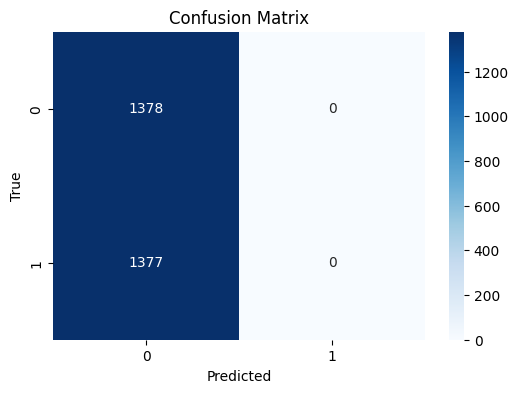

In [ ]:
cm = confusion_matrix(y_test["type_output"], pred_class_bin)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### F1-score

The model achieves not very high overall accuracy (50%), a quite strong F1-score for negative classe and a very low one for the positive. It predicts class 1 very well (recall = 1.00), but struggles to correctly identify all class 0 instances (recall = 0.00), suggesting a bias toward class 1.

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test["type_output"], pred_class_bin))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1378
           1       0.00      0.00      0.00      1377

    accuracy                           0.50      2755
   macro avg       0.25      0.50      0.33      2755
weighted avg       0.25      0.50      0.33      2755



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Regression**

### MSE

Mean Squared Error measures the average of the squared differences between predicted and actual values, penalizing more heavily larger errors.

Given that the target ranges only from 2.5 to 10, an RMSE (Squared Root of MSE) of around 7.99 is extremely high, suggesting the model’s predictions are often off by almost the entire span of possible values. This indicates the model is struggling to learn meaningful patterns for the regression task. It would be advisable to revisit feature preprocessing, potentially normalize or standardize the target, reconsider model complexity, and explore more robust hyperparameter tuning to improve performance.

In [ ]:
print("\nRegression MSE:")
print(mean_squared_error(y_test["score_output"], pred_reg))


Regression MSE:
104.76980156821324
